In [1]:
1# Import required libraries

import pandas as pd
import requests
from io import StringIO

In [2]:
2# Call functions to perform Operations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import xarray as xr
import glob
from scipy import stats
from scipy.stats import linregress
from pathlib import Path
import xml.etree.ElementTree as ET

In [3]:
3# CONFIGURAITON Load the KML file from local PC and parse it
# Farm name - adjust this if needed
farm_name = 'Anameka'
kml_file_path = f'C:\\Users\\ibian\\Desktop\\ClimAdapt\\CMIP6\\kml files\\{farm_name}\\PROJ0025_GIS_Anameka_Farms.kml'

# Read the KML file from local path
with open(kml_file_path, 'r', encoding='utf-8') as f:
    kml_content = f.read()

# Parse the KML content using ElementTree
kml_tree = ET.ElementTree(ET.fromstring(kml_content))
kml_root = kml_tree.getroot()

print("KML file loaded and parsed successfully.")

KML file loaded and parsed successfully.


In [4]:
4# Extract farm middle point coordinate from the KML file
from shapely.geometry import Polygon, Point
import warnings

# Find all Polygon coordinates in the KML (assuming standard KML structure)
namespaces = {'kml': 'http://www.opengis.net/kml/2.2'}
coords_list = []
for placemark in kml_root.findall('.//kml:Placemark', namespaces):
    polygon = placemark.find('.//kml:Polygon', namespaces)
    if polygon is not None:
        coords = polygon.find('.//kml:coordinates', namespaces)
        if coords is not None and coords.text:
            # Coordinates are in the form: lon,lat[,alt] separated by spaces or newlines
            coord_pairs = [c.strip() for c in coords.text.replace('\n', ' ').split() if c.strip()]
            try:
                points = [tuple(map(float, c.split(',')[:2])) for c in coord_pairs]
                if len(points) >= 3:  # Valid polygon needs at least 3 points
                    coords_list.append(points)
            except Exception as e:
                warnings.warn(f"Error parsing coordinates: {e}")

if coords_list:
    # Use the first polygon found (or loop for all if needed)
    poly = Polygon(coords_list[0])
    if poly.is_valid and not poly.is_empty:
        centroid = poly.centroid
        middle_point = (centroid.x, centroid.y)
        print(f"Farm middle point coordinate: {middle_point}")
    else:
        print("Polygon is invalid or empty.")
else:
    print("No polygon coordinates found in the KML.")

Farm middle point coordinate: (117.66263846366665, -31.744267057666633)


In [5]:
# SILO API Client 
class SILOWeatherAPI:
    def __init__(self, username: str, password: str):
        self.username = username
        self.password = password
        self.api_base_url = "https://www.longpaddock.qld.gov.au/cgi-bin/silo"

    def get_silo_data(self, lat: float, lon: float, start_year: int, end_year: int, format: str = "fao56"):
        import urllib.parse
        import urllib.request
        
        # Correct SILO API parameters
        params = {
            'format': "fao56" if format == "fao56" else "daily",
            'lat': str(round(lat, 4)),
            'lon': str(round(lon, 4)),
            'start': f"{start_year}0101",
            'finish': f"{end_year}1231",
            'username': self.username,
            'password': self.password
        }
        
        # Use correct SILO endpoint
        url = f"{self.api_base_url}/DataDrillDataset.php?" + urllib.parse.urlencode(params)
        
        print(f"🔄 Fetching data for Point ({lat:.4f}, {lon:.4f})...")
        print(f"📡 URL: {url}")
        
        try:
            with urllib.request.urlopen(url, timeout=30) as response:
                data = response.read().decode('utf-8')
                
            # Check if we got valid data
            if "Date" in data and len(data) > 100:
                # Process the SILO format
                lines = data.strip().split('\n')
                
                # Find data start (skip header lines)
                data_start = None
                for i, line in enumerate(lines):
                    if not line.startswith('"') and not line.startswith('!') and line.strip():
                        parts = line.split()
                        if len(parts) >= 3:
                            data_start = i
                            break
                
                if data_start is not None:
                    data_lines = lines[data_start:]
                    df = pd.read_csv(StringIO('\n'.join(data_lines)), delim_whitespace=True)
                    
                    # Clean the data
                    if 'Date' in df.columns:
                        df = df[df['Date'] != '(yyyymmdd)'].copy()
                        df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
                        
                        # Convert numeric columns
                        for col in df.columns:
                            if col != 'Date':
                                df[col] = pd.to_numeric(df[col], errors='coerce')
                        
                        print(f"✅ Success! Retrieved {len(df)} days of data")
                        return df
                    else:
                        print(f"❌ No Date column found. Columns: {df.columns.tolist()}")
                        return None
                else:
                    print(f"❌ Could not find data start in response")
                    return None
            else:
                print(f"❌ Invalid response. Response length: {len(data)}")
                print(f"First 200 chars: {data[:200]}")
                return None
                
        except Exception as e:
            print(f"❌ Error fetching data: {e}")
            return None

# Set credentials and parameters 
username = 'ibianchi@arcasustain.com.au'
password = 'password'  # Use your actual SILO password
start_year = 1981
end_year = 2024

# Use the middle point (centroid) extracted earlier
if 'middle_point' in globals():
    mid_lon, mid_lat = middle_point
    print(f"\nFetching SILO data for farm centroid: ({mid_lat:.4f}, {mid_lon:.4f})")
    api = SILOWeatherAPI(username, password)
    test_df = api.get_silo_data(mid_lat, mid_lon, start_year, end_year)
    if test_df is not None and not test_df.empty:
        print(f"✅ SILO API connection successful for centroid. Sample data:")
        print(test_df.head())
    else:
        print(f"❌ SILO API connection failed for centroid.")


Fetching SILO data for farm centroid: (-31.7443, 117.6626)
🔄 Fetching data for Point (-31.7443, 117.6626)...
📡 URL: https://www.longpaddock.qld.gov.au/cgi-bin/silo/DataDrillDataset.php?format=fao56&lat=-31.7443&lon=117.6626&start=19810101&finish=20241231&username=ibianchi%40arcasustain.com.au&password=password
✅ Success! Retrieved 16071 days of data
✅ SILO API connection successful for centroid. Sample data:
        Date  Day  Date2  T.Max  Smx  T.Min  Smn  Rain  Srn  Evap  Sev  Radn  \
1 1981-01-01    1    NaN   32.3   25   14.3   25   0.0   25  11.2   25  31.8   
2 1981-01-02    2    NaN   32.5   25   18.0   25   0.0   25  13.0   25  26.8   
3 1981-01-03    3    NaN   36.8   25   15.7   25   0.0   25  15.2   25  31.2   
4 1981-01-04    4    NaN   30.5   25   21.7   25   0.0   25   5.1   25   8.1   
5 1981-01-05    5    NaN   39.6   25   16.9   25   2.2   25  15.3   25  31.6   

   Ssl    VP  Svp  RHmaxT  RHminT  FAO56  
1   25  12.4   25    25.6    76.1    7.3  
2   25  12.8   25   

C:\Users\ibian\AppData\Local\Temp\ipykernel_48188\1055793107.py:49: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(StringIO('\n'.join(data_lines)), delim_whitespace=True)


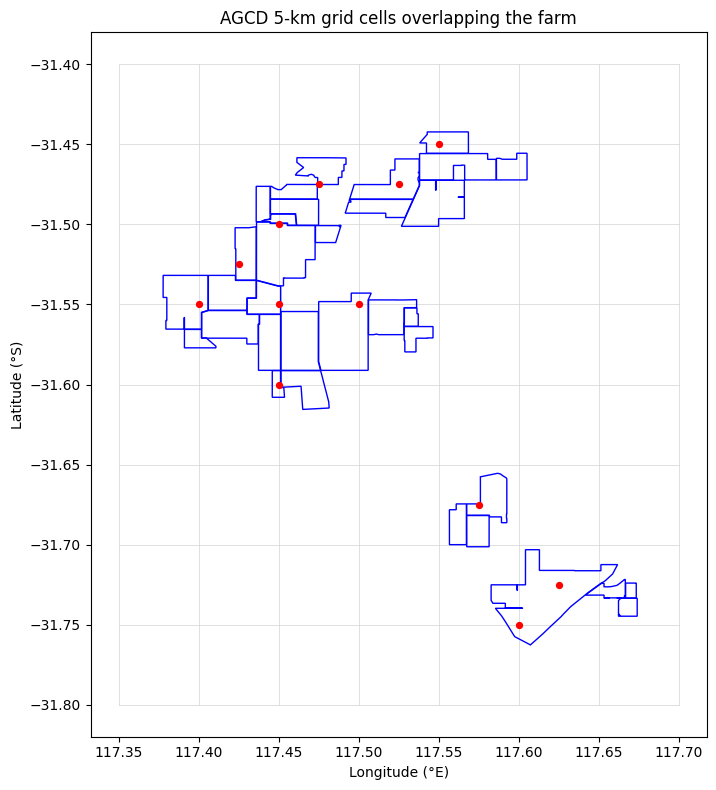

Grid cells covering the farm (longitude, latitude):
117.600, -31.750
117.625, -31.725
117.575, -31.675
117.450, -31.600
117.400, -31.550
117.450, -31.550
117.500, -31.550
117.425, -31.525
117.450, -31.500
117.475, -31.475
117.525, -31.475
117.550, -31.450


In [6]:
# Extract coordinates and Overlay 5‑km Climate Grid on kml file

import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.path as mpath
import matplotlib.pyplot as plt

# ---------- Prerequisite ----------
# Expects `kml_content` string already defined from your earlier S3 download step.
# Example upstream:
# kml_obj = s3_client.get_object(Bucket=BUCKET_NAME, Key=kml_key)
# kml_content = kml_obj['Body'].read().decode('utf-8')

if 'kml_content' not in globals() or not kml_content:
    raise RuntimeError("kml_content not found. Run the KML download cell first to set `kml_content`.")

# ---------- 1) Parse KML ----------
kml_tree = ET.ElementTree(ET.fromstring(kml_content))
kml_root = kml_tree.getroot()

# ---------- 2) AGCD grid parameters ----------
# AGCD (AUS) ~5 km grid reference (lon0, lat0) and step in degrees
lon0, lat0 = 111.975, -44.525
step = 0.05  # degrees ~ 5 km

# ---------- 3) Extract polygons (outer rings only) ----------
# If your KML has holes (innerBoundaryIs), this simple approach ignores holes.
# Add handling if required.
ns = {'kml': 'http://www.opengis.net/kml/2.2'}
polygons = []
for poly_elem in kml_root.findall('.//kml:Polygon', ns):
    coords_el = poly_elem.find('.//kml:outerBoundaryIs/kml:LinearRing/kml:coordinates', ns)
    if coords_el is None or not coords_el.text:
        # fallback to any coordinates node
        coords_el = poly_elem.find('.//kml:coordinates', ns)
    if coords_el is None or not coords_el.text:
        continue
    coords_text = coords_el.text.strip()
    # KML order: lon,lat[,alt]
    coords = []
    for c in coords_text.split():
        parts = c.split(',')[:2]
        try:
            lon, lat = float(parts[0]), float(parts[1])
            coords.append((lon, lat))
        except Exception:
            continue
    if len(coords) >= 3:
        # Ensure ring closed for Path consistency
        if coords[0] != coords[-1]:
            coords.append(coords[0])
        polygons.append(coords)

if not polygons:
    raise ValueError("No polygons extracted from KML. Check structure/namespaces.")

# ---------- 4) Bounding box ----------
all_lons = [lon for poly in polygons for lon, lat in poly]
all_lats = [lat for poly in polygons for lon, lat in poly]
min_lat, max_lat = min(all_lats), max(all_lats)
min_lon, max_lon = min(all_lons), max(all_lons)

# ---------- 5) Select grid points overlapping the farm ----------
poly_paths = [mpath.Path(np.array(poly, dtype=float)) for poly in polygons]
selected_points = set()

# 5a: cell centers
imin_c = int(np.floor((min_lat - lat0) / step - 0.5))
imax_c = int(np.ceil((max_lat - lat0) / step - 0.5))
jmin_c = int(np.floor((min_lon - lon0) / step - 0.5))
jmax_c = int(np.ceil((max_lon - lon0) / step - 0.5))

for i in range(imin_c, imax_c + 1):
    lat_center = lat0 + step * (i + 0.5)
    for j in range(jmin_c, jmax_c + 1):
        lon_center = lon0 + step * (j + 0.5)
        if any(path.contains_point((lon_center, lat_center)) for path in poly_paths):
            selected_points.add((lon_center, lat_center))

# 5b: grid nodes (corners)
imin_n = int(np.floor((min_lat - lat0) / step - 1))
imax_n = int(np.ceil((max_lat - lat0) / step + 1))
jmin_n = int(np.floor((min_lon - lon0) / step - 1))
jmax_n = int(np.ceil((max_lon - lon0) / step + 1))

for i in range(imin_n, imax_n + 1):
    lat_node = lat0 + step * i
    for j in range(jmin_n, jmax_n + 1):
        lon_node = lon0 + step * j
        if any(path.contains_point((lon_node, lat_node)) for path in poly_paths):
            selected_points.add((lon_node, lat_node))

# ---------- 6) Plot ----------
fig, ax = plt.subplots(figsize=(8, 8))

# Polygons
for poly in polygons:
    xs = [p[0] for p in poly]
    ys = [p[1] for p in poly]
    ax.fill(xs, ys, edgecolor="blue", fill=False, linewidth=1)

# Grid lines (for reference)
lat_lines = np.arange(np.floor(min_lat/step)*step, np.ceil(max_lat/step)*step + step, step)
lon_lines = np.arange(np.floor(min_lon/step)*step, np.ceil(max_lon/step)*step + step, step)
for lat in lat_lines:
    ax.plot([lon_lines.min(), lon_lines.max()], [lat, lat], color='lightgray', linewidth=0.5, zorder=0)
for lon in lon_lines:
    ax.plot([lon, lon], [lat_lines.min(), lat_lines.max()], color='lightgray', linewidth=0.5, zorder=0)

# Selected points
if selected_points:
    sel_lons, sel_lats = zip(*sorted(selected_points))
    ax.scatter(sel_lons, sel_lats, color='red', s=18, marker='o', zorder=2)

ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°S)")
ax.set_title("AGCD 5‑km grid cells overlapping the farm")
ax.set_aspect("equal", adjustable="box")
plt.tight_layout()
plt.show()

# ---------- 7) Print selected grid coordinates ----------
print("Grid cells covering the farm (longitude, latitude):")
for lon, lat in sorted(selected_points, key=lambda x: (x[1], x[0])):
    print(f"{lon:.3f}, {lat:.3f}")

# Make available as a list variable for downstream use
selected_agcd_points = sorted(selected_points, key=lambda x: (x[1], x[0]))

Label -> (lon, lat)
A: (117.60000, -31.75000)
B: (117.62500, -31.72500)
C: (117.57500, -31.67500)
D: (117.45000, -31.60000)
E: (117.40000, -31.55000)
F: (117.45000, -31.55000)
G: (117.50000, -31.55000)
H: (117.42500, -31.52500)
I: (117.45000, -31.50000)
J: (117.47500, -31.47500)
K: (117.52500, -31.47500)
L: (117.55000, -31.45000)
✅ Map image saved: C:\Users\ibian\Desktop\ClimAdapt\Anameka\Anameka_grid_coordinates.png


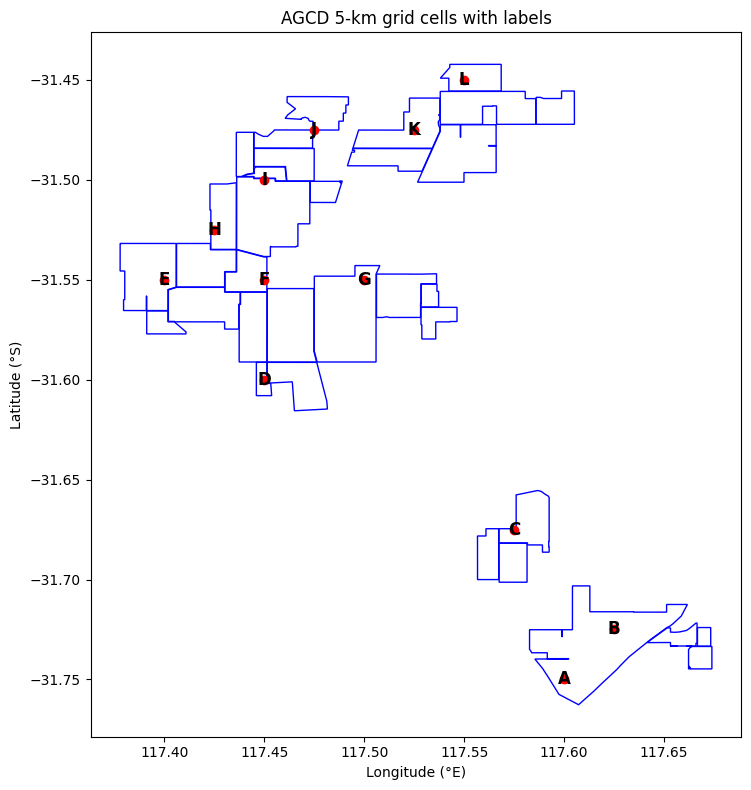

In [7]:
# Assign labels to selected grid points and plot map with names

import string
import numpy as np
import matplotlib.pyplot as plt

# ---------- Inputs ----------
# Prefer the variable produced by the grid overlay cell; fall back if needed
if 'selected_agcd_points' in globals() and selected_agcd_points:
    points_in = list(selected_agcd_points)
elif 'selected_points' in globals() and selected_points:
    points_in = list(selected_points)
else:
    raise RuntimeError("No selected points found. Run the AGCD 5-km grid overlay cell first.")

# Polygons must be defined from the KML parsing step for plotting
if 'polygons' not in globals() or not polygons:
    raise RuntimeError("No polygons available. Ensure the KML polygons have been parsed into `polygons`.")

# ---------- Helpers ----------
def excel_label(n: int) -> str:
    """
    Convert 0-based integer n to Excel-style label:
    0->A, 1->B, ..., 25->Z, 26->AA, 27->AB, ...
    """
    n = n + 1  # convert to 1-based
    s = []
    while n > 0:
        n, r = divmod(n - 1, 26)
        s.append(string.ascii_uppercase[r])
    return ''.join(reversed(s))

# ---------- Create labels ----------
# Sort by latitude, then longitude for consistent labeling
sorted_points = sorted(points_in, key=lambda x: (x[1], x[0]))

# Generate labels (A..Z, AA..)
labels = [excel_label(i) for i in range(len(sorted_points))]

# Map each grid location to its label
grid_labels = {pt: labels[i] for i, pt in enumerate(sorted_points)}

# Also expose a convenient list of dicts for downstream use
labeled_points = [
    {"label": grid_labels[pt], "lon": float(pt[0]), "lat": float(pt[1])}
    for pt in sorted_points
]

# Print mapping
print("Label -> (lon, lat)")
for item in labeled_points:
    print(f"{item['label']}: ({item['lon']:.5f}, {item['lat']:.5f})")

# ---------- Plot polygons and labeled grid points ----------
fig, ax = plt.subplots(figsize=(8, 8))

# Draw polygons
for poly in polygons:
    xs = [p[0] for p in poly]
    ys = [p[1] for p in poly]
    ax.fill(xs, ys, edgecolor="blue", fill=False, linewidth=1)

# Plot points with labels
for pt in sorted_points:
    label = grid_labels[pt]
    ax.scatter(pt[0], pt[1], color='red', marker='o', zorder=3)
    ax.text(pt[0], pt[1], label, color='black', fontsize=12,
            ha='center', va='center', fontweight='bold', zorder=4)

ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°S)")
ax.set_title("AGCD 5‑km grid cells with labels")
ax.set_aspect("equal", adjustable="box")
plt.tight_layout()

# Save the map image before showing
from pathlib import Path
output_dir = Path(f'C:\\Users\\ibian\\Desktop\\ClimAdapt\\{farm_name}')
output_dir.mkdir(parents=True, exist_ok=True)
map_image_path = output_dir / f'{farm_name}_grid_coordinates.png'
fig.savefig(map_image_path, dpi=300, bbox_inches='tight')
print(f"✅ Map image saved: {map_image_path}")

plt.show()

# `grid_labels` and `labeled_points` now available for downstream usage

In [8]:
# Create CSV file with labeled grid point coordinates
import os
from pathlib import Path

# Ensure labeled_points exists
if 'labeled_points' not in globals() or not labeled_points:
    raise RuntimeError("No labeled_points found. Run the labeling cell first.")

# Create output directory if it doesn't exist
output_dir = Path(f'C:\\Users\\ibian\\Desktop\\ClimAdapt\\{farm_name}')
output_dir.mkdir(parents=True, exist_ok=True)

# Create DataFrame from labeled_points
df_coords = pd.DataFrame(labeled_points)

# Add a Coordinates column in the format: (lon, lat)
df_coords['Coordinates'] = df_coords.apply(
    lambda row: f"({row['lon']:.5f}, {row['lat']:.5f})", axis=1
)

# Reorder columns: Label, Coordinates, Longitude, Latitude
df_coords = df_coords[['label', 'Coordinates', 'lon', 'lat']]

# Rename columns for clarity
df_coords.columns = ['Label', 'Coordinates', 'Longitude', 'Latitude']

# Save to CSV with farm name prefix
output_csv = output_dir / f'{farm_name}_grid_coordinates.csv'
df_coords.to_csv(output_csv, index=False)

print(f"✅ CSV file created successfully!")
print(f"📁 Location: {output_csv}")
print(f"\n📊 Contents:")
print(df_coords.to_string(index=False))

✅ CSV file created successfully!
📁 Location: C:\Users\ibian\Desktop\ClimAdapt\Anameka\Anameka_grid_coordinates.csv

📊 Contents:
Label            Coordinates  Longitude  Latitude
    A (117.60000, -31.75000)    117.600   -31.750
    B (117.62500, -31.72500)    117.625   -31.725
    C (117.57500, -31.67500)    117.575   -31.675
    D (117.45000, -31.60000)    117.450   -31.600
    E (117.40000, -31.55000)    117.400   -31.550
    F (117.45000, -31.55000)    117.450   -31.550
    G (117.50000, -31.55000)    117.500   -31.550
    H (117.42500, -31.52500)    117.425   -31.525
    I (117.45000, -31.50000)    117.450   -31.500
    J (117.47500, -31.47500)    117.475   -31.475
    K (117.52500, -31.47500)    117.525   -31.475
    L (117.55000, -31.45000)    117.550   -31.450


In [9]:
# [EXPORT] SILO per-point CSVs and ALL-POINTS CSV (1981–2020) with required schema

import time
from pathlib import Path
import pandas as pd

# ---------- Prerequisites ----------
# Expects the SILO client and credentials to be already set up in earlier cells:
# class SILOWeatherAPI(...); api = SILOWeatherAPI(username, password)
if 'SILOWeatherAPI' not in globals():
    raise RuntimeError("SILOWeatherAPI is not defined. Run your SILO API client cell first.")
if 'api' not in globals() or api is None:
    raise RuntimeError("`api` instance not found. Please create: api = SILOWeatherAPI(username, password)")

# Points to process: prefer labeled_points from the labeling step
def _excel_label(n: int) -> str:
    n = n + 1
    s = []
    import string
    while n > 0:
        n, r = divmod(n - 1, 26)
        s.append(string.ascii_uppercase[r])
    return ''.join(reversed(s))

if 'labeled_points' in globals() and labeled_points:
    points = [{"label": lp["label"], "lon": float(lp["lon"]), "lat": float(lp["lat"])} for lp in labeled_points]
elif 'selected_agcd_points' in globals() and selected_agcd_points:
    pts_sorted = sorted(selected_agcd_points, key=lambda x: (x[1], x[0]))
    points = [{"label": _excel_label(i), "lon": float(pt[0]), "lat": float(pt[1])} for i, pt in enumerate(pts_sorted)]
else:
    raise RuntimeError("No points found. Run the grid overlay + labeling cells first.")

# ---------- Config ----------
START_YEAR, END_YEAR = 1981, 2020
MODEL = "SILO"
SCENARIO = "historical"
MEMBER = "NA"
DOMAIN = "point"

# ---------- Paths ----------
try:
    PROJECT_ROOT = Path(__file__).resolve().parent.parent
except NameError:
    PROJECT_ROOT = Path.cwd().resolve()
OUTPUT_DIR = PROJECT_ROOT / "outputs"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
POINTS_OUT_DIR = OUTPUT_DIR / "points"
POINTS_OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---------- Helpers ----------
def fetch_point_df(api, qlat: float, qlon: float, start_year: int, end_year: int, retry: int = 2, sleep_s: float = 1.0):
    """
    Fetch daily SILO data for a single coordinate.
    Returns a DataFrame with columns: time, year, month, pr, query_lat, query_lon, lat_selected, lon_selected
    """
    last_exc = None
    for attempt in range(retry + 1):
        try:
            df = api.get_silo_data(qlat, qlon, start_year, end_year)  # returns a DataFrame or None
            if df is None or df.empty:
                raise ValueError("Empty SILO response")
            # Normalize expected columns
            if "Date" not in df.columns:
                raise ValueError("SILO response missing 'Date' column.")
            # Try common rainfall names; your SILO FAO56 response should have 'Rain'
            rain_col = "Rain" if "Rain" in df.columns else None
            if rain_col is None:
                # try some variations
                for c in df.columns:
                    if str(c).lower() in {"rain", "precip", "precipitation", "pr"}:
                        rain_col = c
                        break
            if rain_col is None:
                raise ValueError(f"Could not find a rainfall column in SILO response: {df.columns.tolist()}")

            out = df.copy()
            out["time"] = pd.to_datetime(out["Date"])
            out["year"] = out["time"].dt.year
            out["month"] = out["time"].dt.month
            out = out.rename(columns={rain_col: "pr"})
            # align output columns
            out = out[["time","year","month","pr"]]
            # Add query/selected metadata
            out["query_lat"] = float(qlat)
            out["query_lon"] = float(qlon)
            # DataDrill returns interpolated values at the query point; we use the query coords as selected
            out["lat_selected"] = float(qlat)
            out["lon_selected"] = float(qlon)
            return out
        except Exception as e:
            last_exc = e
            time.sleep(sleep_s)
    raise RuntimeError(f"Failed to fetch SILO data for ({qlat},{qlon}) after {retry+1} attempts: {last_exc}")

# ---------- Process all points ----------
all_frames = []
for pt in points:
    label, qlon, qlat = pt["label"], pt["lon"], pt["lat"]
    print(f"→ Fetching SILO for {label} at ({qlat:.4f}, {qlon:.4f}) {START_YEAR}-{END_YEAR}")
    try:
        dfp = fetch_point_df(api, qlat, qlon, START_YEAR, END_YEAR)
        # Insert label and SILO meta
        dfp.insert(0, "label", label)
        dfp["model"] = MODEL
        dfp["scenario"] = SCENARIO
        dfp["member"] = MEMBER
        dfp["domain"] = DOMAIN
        # Provide a source string for traceability (no credentials)
        dfp["source_path"] = f"SILO DataDrill FAO56 ({qlat:.4f},{qlon:.4f}) {START_YEAR}-{END_YEAR}"

        # Exact column order
        dfp = dfp[[
            "label","time","year","month","pr","query_lat","query_lon",
            "lat_selected","lon_selected","model","scenario","member","domain","source_path"
        ]]

        # Sort for stable output
        dfp = dfp.sort_values(["time"]).reset_index(drop=True)

        # Save per-point CSV
        out_csv = POINTS_OUT_DIR / f"{label}.csv"
        dfp.to_csv(out_csv, index=False)
        print(f"✅ Saved {out_csv}")

        all_frames.append(dfp)
    except Exception as e:
        print(f"⚠️ Skipped {label}: {e}")

# ---------- Save ALL-POINTS combined ----------
if all_frames:
    df_all = pd.concat(all_frames, ignore_index=True)
    df_all = df_all.sort_values(["label","time"]).reset_index(drop=True)
    all_csv = OUTPUT_DIR / "ALL_POINTS_timeseries_SILO.csv"
    df_all.to_csv(all_csv, index=False)
    print(f"✅ Saved ALL-POINTS: {all_csv}")
else:
    print("⚠️ No per-point files created; ALL-POINTS not written.")

→ Fetching SILO for A at (-31.7500, 117.6000) 1981-2020
🔄 Fetching data for Point (-31.7500, 117.6000)...
📡 URL: https://www.longpaddock.qld.gov.au/cgi-bin/silo/DataDrillDataset.php?format=fao56&lat=-31.75&lon=117.6&start=19810101&finish=20201231&username=ibianchi%40arcasustain.com.au&password=password


C:\Users\ibian\AppData\Local\Temp\ipykernel_48188\1055793107.py:49: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(StringIO('\n'.join(data_lines)), delim_whitespace=True)


✅ Success! Retrieved 14610 days of data
✅ Saved C:\Users\ibian\Desktop\ClimAdapt\Anameka\Grid\Anameka\outputs\points\A.csv
→ Fetching SILO for B at (-31.7250, 117.6250) 1981-2020
🔄 Fetching data for Point (-31.7250, 117.6250)...
📡 URL: https://www.longpaddock.qld.gov.au/cgi-bin/silo/DataDrillDataset.php?format=fao56&lat=-31.725&lon=117.625&start=19810101&finish=20201231&username=ibianchi%40arcasustain.com.au&password=password


C:\Users\ibian\AppData\Local\Temp\ipykernel_48188\1055793107.py:49: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(StringIO('\n'.join(data_lines)), delim_whitespace=True)


✅ Success! Retrieved 14610 days of data
✅ Saved C:\Users\ibian\Desktop\ClimAdapt\Anameka\Grid\Anameka\outputs\points\B.csv
→ Fetching SILO for C at (-31.6750, 117.5750) 1981-2020
🔄 Fetching data for Point (-31.6750, 117.5750)...
📡 URL: https://www.longpaddock.qld.gov.au/cgi-bin/silo/DataDrillDataset.php?format=fao56&lat=-31.675&lon=117.575&start=19810101&finish=20201231&username=ibianchi%40arcasustain.com.au&password=password


C:\Users\ibian\AppData\Local\Temp\ipykernel_48188\1055793107.py:49: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(StringIO('\n'.join(data_lines)), delim_whitespace=True)


✅ Success! Retrieved 14610 days of data
✅ Saved C:\Users\ibian\Desktop\ClimAdapt\Anameka\Grid\Anameka\outputs\points\C.csv
→ Fetching SILO for D at (-31.6000, 117.4500) 1981-2020
🔄 Fetching data for Point (-31.6000, 117.4500)...
📡 URL: https://www.longpaddock.qld.gov.au/cgi-bin/silo/DataDrillDataset.php?format=fao56&lat=-31.6&lon=117.45&start=19810101&finish=20201231&username=ibianchi%40arcasustain.com.au&password=password


C:\Users\ibian\AppData\Local\Temp\ipykernel_48188\1055793107.py:49: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(StringIO('\n'.join(data_lines)), delim_whitespace=True)


✅ Success! Retrieved 14610 days of data
✅ Saved C:\Users\ibian\Desktop\ClimAdapt\Anameka\Grid\Anameka\outputs\points\D.csv
→ Fetching SILO for E at (-31.5500, 117.4000) 1981-2020
🔄 Fetching data for Point (-31.5500, 117.4000)...
📡 URL: https://www.longpaddock.qld.gov.au/cgi-bin/silo/DataDrillDataset.php?format=fao56&lat=-31.55&lon=117.4&start=19810101&finish=20201231&username=ibianchi%40arcasustain.com.au&password=password


C:\Users\ibian\AppData\Local\Temp\ipykernel_48188\1055793107.py:49: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(StringIO('\n'.join(data_lines)), delim_whitespace=True)


✅ Success! Retrieved 14610 days of data
✅ Saved C:\Users\ibian\Desktop\ClimAdapt\Anameka\Grid\Anameka\outputs\points\E.csv
→ Fetching SILO for F at (-31.5500, 117.4500) 1981-2020
🔄 Fetching data for Point (-31.5500, 117.4500)...
📡 URL: https://www.longpaddock.qld.gov.au/cgi-bin/silo/DataDrillDataset.php?format=fao56&lat=-31.55&lon=117.45&start=19810101&finish=20201231&username=ibianchi%40arcasustain.com.au&password=password


C:\Users\ibian\AppData\Local\Temp\ipykernel_48188\1055793107.py:49: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(StringIO('\n'.join(data_lines)), delim_whitespace=True)


✅ Success! Retrieved 14610 days of data
✅ Saved C:\Users\ibian\Desktop\ClimAdapt\Anameka\Grid\Anameka\outputs\points\F.csv
→ Fetching SILO for G at (-31.5500, 117.5000) 1981-2020
🔄 Fetching data for Point (-31.5500, 117.5000)...
📡 URL: https://www.longpaddock.qld.gov.au/cgi-bin/silo/DataDrillDataset.php?format=fao56&lat=-31.55&lon=117.5&start=19810101&finish=20201231&username=ibianchi%40arcasustain.com.au&password=password


C:\Users\ibian\AppData\Local\Temp\ipykernel_48188\1055793107.py:49: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(StringIO('\n'.join(data_lines)), delim_whitespace=True)


✅ Success! Retrieved 14610 days of data
✅ Saved C:\Users\ibian\Desktop\ClimAdapt\Anameka\Grid\Anameka\outputs\points\G.csv
→ Fetching SILO for H at (-31.5250, 117.4250) 1981-2020
🔄 Fetching data for Point (-31.5250, 117.4250)...
📡 URL: https://www.longpaddock.qld.gov.au/cgi-bin/silo/DataDrillDataset.php?format=fao56&lat=-31.525&lon=117.425&start=19810101&finish=20201231&username=ibianchi%40arcasustain.com.au&password=password


C:\Users\ibian\AppData\Local\Temp\ipykernel_48188\1055793107.py:49: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(StringIO('\n'.join(data_lines)), delim_whitespace=True)


✅ Success! Retrieved 14610 days of data
✅ Saved C:\Users\ibian\Desktop\ClimAdapt\Anameka\Grid\Anameka\outputs\points\H.csv
→ Fetching SILO for I at (-31.5000, 117.4500) 1981-2020
🔄 Fetching data for Point (-31.5000, 117.4500)...
📡 URL: https://www.longpaddock.qld.gov.au/cgi-bin/silo/DataDrillDataset.php?format=fao56&lat=-31.5&lon=117.45&start=19810101&finish=20201231&username=ibianchi%40arcasustain.com.au&password=password


C:\Users\ibian\AppData\Local\Temp\ipykernel_48188\1055793107.py:49: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(StringIO('\n'.join(data_lines)), delim_whitespace=True)


✅ Success! Retrieved 14610 days of data
✅ Saved C:\Users\ibian\Desktop\ClimAdapt\Anameka\Grid\Anameka\outputs\points\I.csv
→ Fetching SILO for J at (-31.4750, 117.4750) 1981-2020
🔄 Fetching data for Point (-31.4750, 117.4750)...
📡 URL: https://www.longpaddock.qld.gov.au/cgi-bin/silo/DataDrillDataset.php?format=fao56&lat=-31.475&lon=117.475&start=19810101&finish=20201231&username=ibianchi%40arcasustain.com.au&password=password


C:\Users\ibian\AppData\Local\Temp\ipykernel_48188\1055793107.py:49: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(StringIO('\n'.join(data_lines)), delim_whitespace=True)


✅ Success! Retrieved 14610 days of data
✅ Saved C:\Users\ibian\Desktop\ClimAdapt\Anameka\Grid\Anameka\outputs\points\J.csv
→ Fetching SILO for K at (-31.4750, 117.5250) 1981-2020
🔄 Fetching data for Point (-31.4750, 117.5250)...
📡 URL: https://www.longpaddock.qld.gov.au/cgi-bin/silo/DataDrillDataset.php?format=fao56&lat=-31.475&lon=117.525&start=19810101&finish=20201231&username=ibianchi%40arcasustain.com.au&password=password


C:\Users\ibian\AppData\Local\Temp\ipykernel_48188\1055793107.py:49: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(StringIO('\n'.join(data_lines)), delim_whitespace=True)


✅ Success! Retrieved 14610 days of data
✅ Saved C:\Users\ibian\Desktop\ClimAdapt\Anameka\Grid\Anameka\outputs\points\K.csv
→ Fetching SILO for L at (-31.4500, 117.5500) 1981-2020
🔄 Fetching data for Point (-31.4500, 117.5500)...
📡 URL: https://www.longpaddock.qld.gov.au/cgi-bin/silo/DataDrillDataset.php?format=fao56&lat=-31.45&lon=117.55&start=19810101&finish=20201231&username=ibianchi%40arcasustain.com.au&password=password


C:\Users\ibian\AppData\Local\Temp\ipykernel_48188\1055793107.py:49: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(StringIO('\n'.join(data_lines)), delim_whitespace=True)


✅ Success! Retrieved 14610 days of data
✅ Saved C:\Users\ibian\Desktop\ClimAdapt\Anameka\Grid\Anameka\outputs\points\L.csv
✅ Saved ALL-POINTS: C:\Users\ibian\Desktop\ClimAdapt\Anameka\Grid\Anameka\outputs\ALL_POINTS_timeseries_SILO.csv


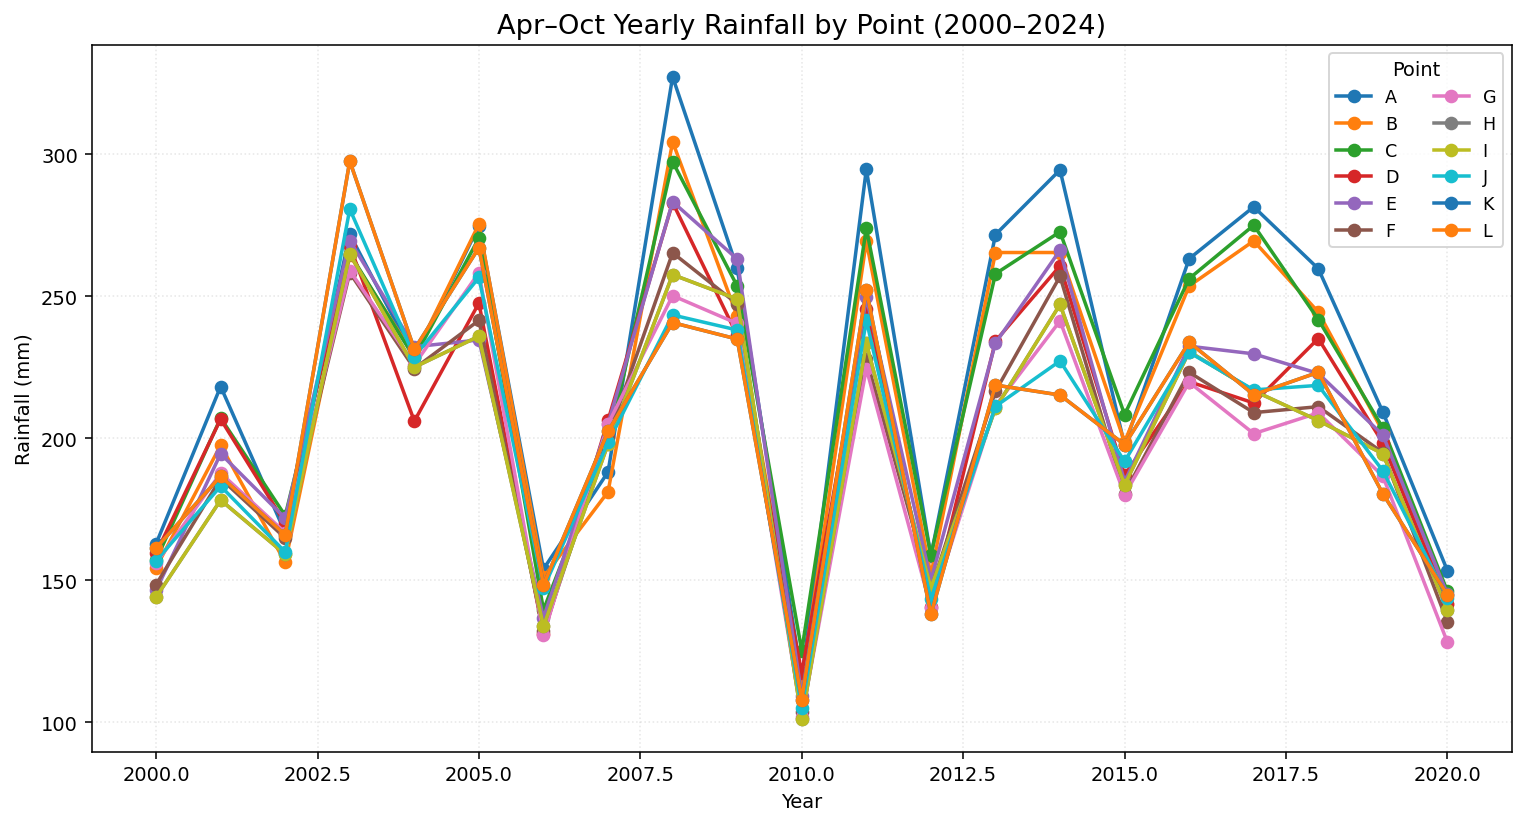

Average yearly rainfall per point (Apr–Oct, 2000–2024):
label
A    226.242857
B    215.819048
C    219.461905
D    205.076190
E    207.680952
F    198.757143
G    196.385714
H    197.876190
I    197.876190
J    200.509524
K    203.014286
L    203.014286
Name: pr, dtype: float64

Overall average across all label-year entries: 205.98 mm/year


In [10]:
# [IMAGE] (POINT) Yearly Accumulated Rainfall GS
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Paths
BASE_DIR = Path(r"C:\Users\ibian\.vscode\SILO (Anamakea Pilot)\outputs")
ALL_POINTS = BASE_DIR / "ALL_POINTS_timeseries_SILO.csv"

# Load
df = pd.read_csv(ALL_POINTS, parse_dates=["time"])

# Ensure 'year' and 'month'
if "year" not in df.columns:
    df["year"] = df["time"].dt.year
if "month" not in df.columns:
    df["month"] = df["time"].dt.month

# Filter years 2000–2024 and months Apr–Oct (4–10)
df_filt = df[(df["year"].between(2000, 2024)) & (df["month"].between(4, 10))].copy()

# Yearly totals per point
yearly_by_point = (
    df_filt.groupby(["label", "year"])["pr"].sum().reset_index()
)

# Pivot for plotting: rows=year, cols=label
pivot = yearly_by_point.pivot(index="year", columns="label", values="pr").sort_index()

# Plot: one line per point
plt.figure(figsize=(11, 6), dpi=140)
for label in pivot.columns:
    plt.plot(pivot.index, pivot[label], marker="o", linewidth=1.8, label=label)

plt.title("Apr–Oct Yearly Rainfall by Point (2000–2024)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Rainfall (mm)")
plt.grid(alpha=0.3, linestyle=":")
plt.legend(title="Point", ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

# Optional: averages (Apr–Oct, 2000–2024)
avg_per_point = yearly_by_point.groupby("label")["pr"].mean().sort_index()
overall_avg = yearly_by_point["pr"].mean()
print("Average yearly rainfall per point (Apr–Oct, 2000–2024):")
print(avg_per_point)
print(f"\nOverall average across all label-year entries: {overall_avg:.2f} mm/year")